# SynCAN Evaluator
Created April 4, 2023

This notebook is used to evaluate trained models (imported via .h5 files) using several testing datasets. Multiple models may be evaluated at a time in order to collect a set of useful results. The intrusion detection threshold may also be adjusted in order to test differences in precision and recall.

# Setup

In [ ]:
!pip install -q dataframe_image
import dataframe_image as dfi

In [ ]:
from psutil import virtual_memory
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(f'GPU: {gpu_info[599:619]}')
ram_gb = virtual_memory().total / 1e9
print(f'RAM: {ram_gb:.1f} GB')

GPU: 
RAM: 13.6 GB


### Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# download project repository
!git clone https://github.com/brendon-felix/VehicleCybersecFL.git &> /dev/null
!cp ./VehicleCybersecFL/anomalydetection/* .

In [ ]:
from functions import *
class SynCAN_Evaluator:
    '''Class used perform anomaly detection evaluation for INDRA-like models
    '''
    def __init__(self, thresh_df, params, verbose=False):
        '''
        Args:
            thresh_df (pd.DataFrame): DataFrame containing normal SynCAN messages, used for calculating thresholds/baseline
            params (dict): dictionary containing parameters for the models and evalutation
            verbose (bool): verbose output
        '''
        if verbose:
            print('Creating threshold dataset...')
        self.thresh_ds, self.thresh_df = create_dataset(thresh_df, params, verbose=verbose)
        self.params = params
        self.verbose = verbose
        self.batch_results = None
        return

    def reconstruct(self, ds, ret_subseqs=False):
        '''Used for reconstructing a tf.Dataset of subsequences into a single reconstruction DataFrame
        Args:
            ds (tf.Dataset): a dataset which contains SynCAN subsequences which will be reconstructed
            ret_subseqs (bool): return the reconstructed subsequences (np.array)
        Returns a pd.DataFrame which should be the same length as the returned df by create_dataset()
        '''
        # used for reconstructing signals with a saved model into a continuous dataframe
        predictions = self.model.predict(ds, verbose=self.verbose, workers=-1, use_multiprocessing=True)
        time_steps = self.params['time_steps']
        seq_stride = self.params['seq_stride']
        if time_steps == seq_stride:
            reconstruction = predictions.reshape(-1, predictions.shape[-1])
        else:
            # remove duplicate timesteps from predictions
            first = predictions[0]
            rest = predictions[1:, time_steps-seq_stride:]
            rest = rest.reshape(-1, rest.shape[-1])
            reconstruction = np.concatenate((first, rest))
        columns = ['Signal'+str(i+1) for i in range(reconstruction.shape[-1])]
        if ret_subseqs:
            return pd.DataFrame(reconstruction, columns=columns), predictions
        else:
            return pd.DataFrame(reconstruction, columns=columns)

    def reconstruct_threshold_data(self):
        '''Used to reconstructed the threshold selection dataset for threshold calculations
        '''
        real_values = self.thresh_df.to_numpy()[:,1:]
        if self.verbose:
            print('Reconstructing threshold-selection data...')
        reconstruction = self.reconstruct(self.thresh_ds)
        reconstructed_values = reconstruction.to_numpy()
        self.thresh_se = np.square(real_values - reconstructed_values)
        return
    
    def set_thresholds(self, num_stds, plot=False, min=False, max=False):
        '''Set a threshold for each message signal
        Args:
            num_stds (int/float): number of standard deviations from the mean used for thresholds
            plot (bool): create a plot showing the thresholds relative to the threshold reconstruction errors
        '''
        if min:
            self.thresholds = np.min(self.thresh_se, axis=0)
        elif max:
            self.thresholds = np.max(self.thresh_se, axis=0)
        else:
            self.thresholds = self.thresh_se.mean(axis=0) + (num_stds * self.thresh_se.std(axis=0))
        if self.verbose:
            print('Setting squared-error thresholds...')
            for i, t in enumerate(self.thresholds):
                print(f'Signal {str(i+1)}: {t:.5}')
        if plot:
            self.plot_error_thresholds(self.thresh_se)
        return
    
    def plot_error_thresholds(self, squared_error):
        '''Function used for showing the thresholds relative to the threshold reconstruction errors
        Args:
            squared_error (np.array): squared error values calculated from the threshold reconstruction
        '''
        num_signals = params['num_signals']
        fig, axes = plt.subplots(nrows=num_signals, ncols=1, figsize=(13, 2*num_signals))
        for i in range(num_signals): # Plot histograms of squared error values and mean + threshold lines
            ax = list(axes)[i]
            se = squared_error[:,i]
            sns.set(font_scale = 1)
            sns.set_style("white")
            ax.xlim([0, 2*self.thresholds[i]])
            sns.histplot(np.clip(se, 0, 2 * self.thresholds[i]), bins=50, kde=True, color='grey', ax=ax)
            ax.axvline(x=np.mean(se), color='g', linestyle='--', linewidth=3)
            ax.text(np.mean(se), 250, "Mean", horizontalalignment='left', 
                    size='small', color='black', weight='semibold')
            ax.axvline(x=self.thresholds[i], color='b', linestyle='--', linewidth=3)
            ax.text(self.thresholds[i], 250, "Threshold", horizontalalignment='left', 
                    size='small', color='Blue', weight='semibold')
            ax.xlabel('Squared Error')
            ax.title('Signal '+str(i+1))
            sns.despine()
        plt.tight_layout()
        plt.show()
        return

    def set_message_predictions(self, predictions):
        '''Create message-level predictions from windows predictions and set the evaluation squared error values
        '''
        stride = self.params['seq_stride']
        steps = self.params['time_steps']
        self.predictions = np.zeros(len(self.evaluation_df), dtype=int)
        for i, prediction in zip(range(0, len(self.evaluation_df)-steps+1, stride), predictions):
            if prediction == 1:
                self.predictions[i:i+steps] = 1
        real_values = self.evaluation_df.to_numpy()[:,1:]
        reconstructed_values = self.reconstructed_df.to_numpy()
        self.eval_se = np.square(real_values - reconstructed_values)
        return
    
    def create_window_labels(self, message_labels):
        '''Create one label for each evaluation subsequence
        Args:
            message_labels (np.array): array of message specific labels
        Returns an np.array containing one label for each input subsequence
        '''
        if self.verbose:
            print('Labeling reconstructed subsequences...')
        labels = []
        stride = self.params['seq_stride']
        steps = self.params['time_steps']
        for i in range(0, len(message_labels)-steps+1, stride):
            window = message_labels.iloc[i:i+steps]
            if len(window[window==1]) > 0:
                labels.append(1)
            else:
                labels.append(0)
        return np.array(labels)
    
    def create_window_predictions(self, reconstructions):
        '''Create one label for each reconstructed subsequence
        Args:
            reconstructions (np.array): array of reconstructed subsequences
        Returns an np.array containing one label for each reconstructed subsequence
        '''
        if self.verbose:
            print('Creating window predictions...')
        time_steps = self.params['time_steps']
        predictions = []
        indices = range(0, len(self.evaluation_df)-time_steps+1, self.params['seq_stride'])
        values = self.evaluation_df.to_numpy()
        predictions = np.zeros(len(indices), dtype=int)
        for i, (j, reconstruction) in enumerate(zip(indices, reconstructions)):
            real_values = values[j:j+time_steps,1:]
            se = np.square(real_values - reconstruction)
            pred = 1*(se >= self.thresholds)
            predictions[i] = 1 if np.sum(pred) > 0 else 0
        return np.array(predictions)

    def get_results(self, reconstructions):
        '''Calculate metrics using the window labels and window predictions (assumes evaluate() was just called)
        Args:
            reconstructions (np.array): array of reconstructed subsequences
        Returns a dictionary with each metric score
        '''
        y = self.window_labels
        y_hat = self.create_window_predictions(reconstructions)
        if self.verbose:
            print(f'Percentage of anomalous predictions: {np.mean(y_hat==1)*100:.3f}%')
        self.set_message_predictions(y_hat)
        tn, fp, fn, tp = np.sum((y == 0) & (y_hat == 0)), np.sum((y == 0) & (y_hat == 1)), np.sum((y == 1) & (y_hat == 0)), np.sum((y == 1) & (y_hat == 1))
        fp_rate = fp / (fp + tn)
        tp_rate = tp / (tp + fn)
        accuracy = np.mean(np.array(y_hat)==np.array(y))
        bal_accuracy = metrics.balanced_accuracy_score(y, y_hat)
        f1_score = metrics.f1_score(y, y_hat)
        precision = metrics.precision_score(y, y_hat)
        recall = metrics.recall_score(y, y_hat)
        if self.verbose:
            print(f'Accuracy: {accuracy:.5}')
            print(f'Balanced Accuracy: {bal_accuracy:.5}')
            print(f'F1 Score: {f1_score:.5}')
            print(f'Precision Score: {precision:.5}')
            print(f'Recall Score: {recall:.5}')
        return {'False Positive Rate': fp_rate,
                'True Positive Rate': tp_rate,
                'Accuracy': accuracy,
                'Balanced Accuracy': bal_accuracy,
                'F1 Score': f1_score,
                'Precision': precision,
                'Recall': recall}
    
    def evaluate(self, model, eval_df, thresh_stds):
        '''Evaluate the given model using the given evalutaion data
        Args:
            model (tf.keras.Model): a trained INDRA-like Keras model
            eval_df (pd.DataFrame): dataframe containing values from a SynCAN attack test
            thresh_stds (list-like): a list of std values used to evaluate the model
        Returns a pd.DataFrame containing the metric results for each threshold value
        '''
        self.model = model
        print(f'\rReconstructing threshold-selection data...', end='')
        self.reconstruct_threshold_data()
        evaluation_ds, self.evaluation_df = create_dataset(eval_df, self.params, verbose=self.verbose)
        print(f'\rReconstructing evaluation data...', end='')
        self.reconstructed_df, reconstructions = self.reconstruct(evaluation_ds, ret_subseqs=True)
        self.reconstructed_df.set_index(self.evaluation_df.index, inplace=True)
        message_labels = self.evaluation_df['Label']
        self.window_labels = self.create_window_labels(message_labels)
        if self.verbose:
            print(f'Percentage of anomalous windows: {np.mean(self.window_labels==1)*100:.3f}%')
        # if self.verbose:
        #     print(f'Percentage of anomalous messages: {np.mean(self.evaluation_df.Label==1)*100:.3f}%')
        results = []
        thresh_stds = list(thresh_stds)
        print(f'\rUsing threshold {1}/{len(thresh_stds)+2}: min', end='')
        self.set_thresholds(None, plot=False, min=True)
        results.append(self.get_results(reconstructions))
        for i, ts in enumerate(thresh_stds):
            # print(f'\rUsing threshold {i+1}/{len(thresh_stds)+2}: {ts:.4f}', end='')
            print(f'\rUsing threshold {i+1}/{len(thresh_stds)+1}: {ts:.4f}', end='')
            self.set_thresholds(ts, plot=False)
            results.append(self.get_results(reconstructions))
        # print(f'\rUsing threshold {len(thresh_stds)+2}/{len(thresh_stds)+2}: max', end='')
        print()
        # self.set_thresholds(None, plot=False, max=True)
        # results.append(self.get_results(reconstructions))
        self.results_df = pd.DataFrame(results)
        # self.results_df.set_index(['min']+thresh_stds+['max'])
        return self.results_df

    # def batch_evaluate(self, models, model_names, eval_df, thresh_stds):
    #     '''Evaluate a list of models using the given evaluation data and store results
    #     Args:
    #         models (list(tf.keras.Model)): list of trained INDRA-like Keras models
    #         eval_df (pd.DataFrame): dataframe containing values from a SynCAN attack test
    #         thresh_stds (list-like): a list of std values used to evaluate the models
    #     '''
    #     self.model_names = model_names
    #     self.batch_results = []
    #     for model, model_name in zip(models, model_names):
    #         print(f'Evaluating model \"{model_name}\"')
    #         self.batch_results.append(self.evaluate(model, eval_df, thresh_stds))
    #     return

    def batch_evaluate(self, models, model_names, eval_dfs, thresh_stds):
        '''Evaluate a list of models using the given evaluation data and store results
        Args:
            models (list(tf.keras.Model)): list of trained INDRA-like Keras models
            eval_df (pd.DataFrame): dataframe containing values from a SynCAN attack test
            thresh_stds (list-like): a list of std values used to evaluate the models
        '''
        # for model, model_name in zip(models, model_names):
            
        self.model_names = model_names
        self.batch_results = []
        roc_auc_val_dict = {}
        pr_auc_val_dict = {}
        for attack, df in eval_dfs.items():
            print(f'\nEvaluating {attack} attack')
            self.batch_results = []
            for model, model_name in zip(models, model_names):
                print(f'Evaluating model \"{model_name}\"')
                self.batch_results.append(self.evaluate(model, df, thresh_stds))
            roc_auc_vals = self.plot_ROC(title=attack.capitalize()+' Attack ROC Curve', filename=attack+'_roc_curve')
            roc_auc_val_dict[attack] = roc_auc_vals
            pr_auc_vals = self.plot_PR(title=attack.capitalize()+' Attack Precision-Recall Curve', filename=attack+'_pr_curve')
            pr_auc_val_dict[attack] = pr_auc_vals
        return roc_auc_val_dict, pr_auc_val_dict
    
    def plot_ROC(self, title=None, filename=None):
        '''Plot the receiver operating characteristic curve (assumes evaluate() or batch_evaluate() was recently called)
        Args:
            title (str): optional title to use for the plot
            filename (str): specify a filename to save a .png file
        '''
        if self.batch_results:
            auc_val = {}
            for results_df, name in zip(self.batch_results, self.model_names):
                fp_rate = results_df['False Positive Rate']
                fp_rate = list(fp_rate)+[0]
                tp_rate = results_df['True Positive Rate']
                tp_rate = list(tp_rate)+[0]
                auc = metrics.auc(fp_rate, tp_rate)
                auc_val[name] = auc
                label = f'{name}, AUC: {auc:.3f}'
                plt.plot(fp_rate, tp_rate, label=label)
            plt.legend()
        else:
            fp_rate = self.results_df['False Positive Rate']
            fp_rate = list(fp_rate)+[0]
            tp_rate = self.results_df['True Positive Rate']
            tp_rate = list(tp_rate)+[0]
            auc_val = metrics.auc(fp_rate, tp_rate)
            label = f'AUC: {auc_val:.3f}'
            plt.text(0.9, 0.1, label)
            plt.plot(fp_rate, tp_rate)
        if title:
            plt.title(title)
        else:
            plt.title('ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        if filename:
            plt.savefig(filename)
        plt.show()
        return auc_val
    
    def plot_PR(self, title=None, filename=None):
        '''Plot the precision-recall curve (assumes evaluate() or batch_evaluate() was recently called)
        Args:
            title (str): optional title to use for the plot
            filename (str): specify a filename to save a .png file
        '''
        if self.batch_results:
            auc_val = {}
            for results_df, name in zip(self.batch_results, self.model_names):
                precision = results_df['Precision']
                precision = list(precision)+[1]
                recall = results_df['Recall']
                recall = list(recall)+[0]
                auc = metrics.auc(recall, precision)
                auc_val[name] = auc
                label = f'{name}, AUC: {auc:.3f}'
                plt.plot(recall, precision, label=label)
            plt.legend()
        else:
            precision = self.results_df['Precision']
            precision = list(precision)+[1]
            recall = self.results_df['Recall']
            recall = list(recall)+[0]
            plt.plot(recall, precision)
            auc_val = metrics.auc(recall, precision)
            label = f'AUC: {auc_val:.3f}'
            plt.text(0.1, 0.1, label)
        if title:
            plt.title(title)
        else:
            plt.title('Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        if filename:
            plt.savefig(filename)
        plt.show()
        return auc_val
    
    def visualize_reconstruction(self, start_time=0, end_time=None, highlight_anomalies=False, highlight_predictions=False, plot_squared_error=False):
        '''Visualize the current evaluation data and reconstruction
        Args:
            start_time (int/float): specify a starting time used for the plot
            end_time (int/float): specify a end time used for the plot
            highlight_anomalies (bool): highlight the actual anomalous ranges
            highlight_predictions (bool): highlight the predicted anomalous ranges
            plot_squared_error (bool): plot the calculated squared error for each signal
        '''
        # accepts two dataframes of the same length with the same number of signals - keys must be Signal1, Signal2,...
        if self.verbose:
            print('Plotting reconstruction...')
        in_df = self.evaluation_df
        out_df = self.reconstructed_df
        end_time = in_df.index.max() if not end_time else end_time
        data = in_df[((in_df.index >= start_time) & (in_df.index < end_time))]
        reconstructed_data = out_df[((out_df.index >= start_time) & (out_df.index < end_time))]

        num_signals = reconstructed_data.shape[1]
        labels = data.Label
        real_ranges = find_ranges(labels.to_numpy(), data.index)
        pred_ranges = find_ranges(self.predictions, in_df.index)
        msg_id = self.params['msg_id']
        fig, axes = plt.subplots(nrows=num_signals, ncols=1, figsize=(13, 3*num_signals), sharex=True)
        for i in range(num_signals):
            key = 'Signal'+str(i+1)
            t_data = data[key]
            t_reconstructed_data = reconstructed_data[key]
            ax = list(axes)[i]
            ax0 = t_data.plot(ax=ax, color="black", title=msg_id.upper()+'_'+key, rot=25)
            ax1 = t_reconstructed_data.plot(ax=ax, color="red", rot=10)
            ax1.legend(['Original Signal', 'Reconstructed Signal'], loc='upper left')
            if highlight_anomalies:
                for start, end in real_ranges:
                    ax0.axvspan(start, end, color='grey', alpha=0.3)
            if highlight_predictions:
                for start, end in pred_ranges:
                    if end > data.index.min() and start < data.index.max():
                        if start < data.index.min():
                            start = data.index.min()
                        if end > data.index.max():
                            end = data.index.max()
                        ax1.axvspan(start, end, color='red', alpha=0.3)
            if plot_squared_error: # plot squared error
                ax2 = ax0.twinx()
                se = pd.DataFrame(self.eval_se[:,i], index=in_df.index)
                se = se[((in_df.index >= start_time) & (in_df.index < end_time))]
                se.plot(ax=ax2, alpha=0.5)
                ax2.set_ylim([0,self.thresholds[i]*1.5])
                ax2.axhline(self.thresholds[i], linestyle='--', c='red', alpha=0.5)
                ax2.set_ylabel('Squared Error')
                ax2.legend(['Squared Error'], loc='lower left')
        plt.tight_layout()
        plt.show()
        return      


In [ ]:
# import custom modules
%run functions
%run id_labels
# %run SynCAN_Evaluator

In [ ]:
download_SynCAN(num_train_files=1)

Finished


### Set parameters

In [ ]:
def set_params(id, config, batch_size=128):
    id = id      # message ID must be between 1 and 10
    time_steps = config[0]
    params = {
        'msg_id': 'id'+str(id),
        'warm_up': config[1],
        'time_steps': time_steps,
        'seq_stride': time_steps//2,
        'batch_size': batch_size,
        'model_dir': '/content/drive/MyDrive/Senior Design 22-23/Models/',
    }
    return params
id = 5
config = (50, 10)
params = set_params(id=id, config=config)

# Prepare Data


In [ ]:
thresh_df = import_data('SynCAN/train.csv', params['msg_id'])
thresh_df = thresh_df.iloc[:len(thresh_df)//2]

7,417,429 total messages (id1,id2,...,id10)
1,034,952 messages used (id5)
0 anomalous messages out of 1,034,952



In [ ]:
attacks = ['continuous', 'flooding', 'plateau']
eval_dfs = {}
for attack in attacks:
    filename = 'SynCAN/test_'+attack+'.csv'
    print(attack)
    eval_dfs[attack] = import_data(filename, params['msg_id'])
    if attack != 'normal':
        eval_dfs[attack] = clean_labels(eval_dfs[attack], params['msg_id'], real_anomaly_ranges[params['msg_id']][attack])

continuous
2,150,051 total messages (id1,id2,...,id10)
299,992 messages used (id5)
40,090 anomalous messages out of 299,992

flooding
2,575,802 total messages (id1,id2,...,id10)
386,914 messages used (id5)
136,249 anomalous messages out of 386,922

plateau
2,150,051 total messages (id1,id2,...,id10)
299,995 messages used (id5)
48,964 anomalous messages out of 299,995



In [ ]:
# visualize_data(thresh_df, end_time=1e5)

continuous


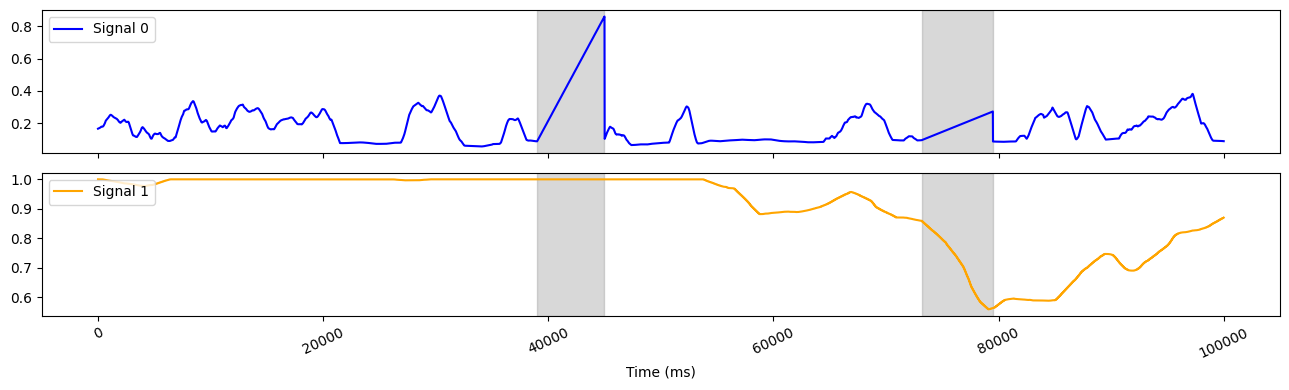

flooding


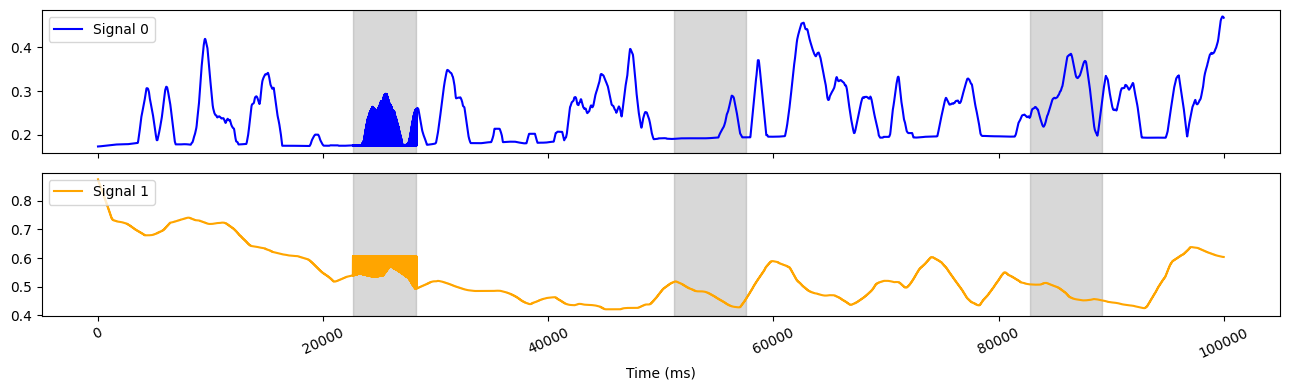

plateau


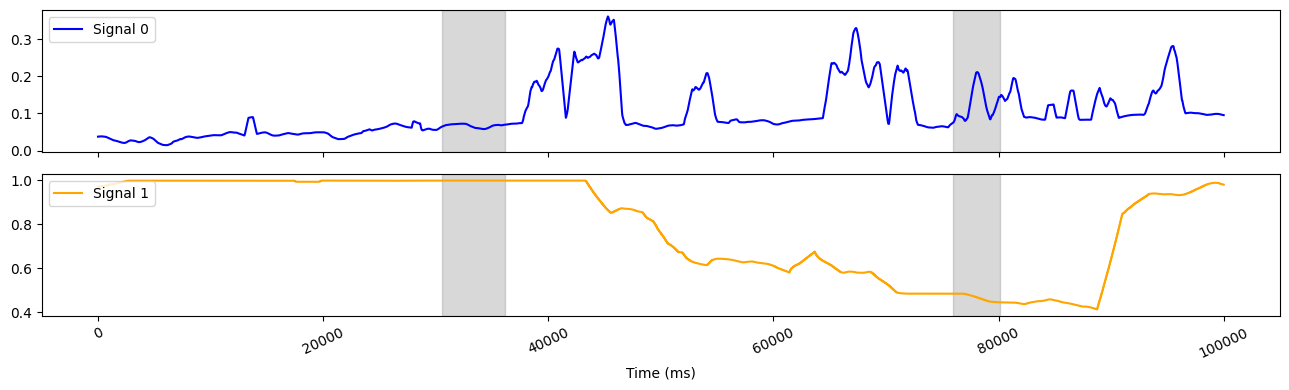

In [ ]:
for attack, df in eval_dfs.items():
    print(attack)
    visualize_data(df, end_time=1e5)

# Evaluate Models

In [ ]:
# model_configs = ((20, 5), (50, 10), (100, 20), (250, 50))
thresh_stds = np.logspace(-2, 4, num=10, base=2)
thresh_stds

array([ 0.25      ,  0.39685026,  0.62996052,  1.        ,  1.58740105,
        2.5198421 ,  4.        ,  6.34960421, 10.0793684 , 16.        ])

In [ ]:
pr_auc_val_list = []
roc_auc_val_list = []
config = (50, 10)
print(f'Using model configuration {config}')
params = set_params(id=id, config=config)
path = params['model_dir']+'CIDS'+str(config[0])+'/id'+str(id)+'/model.h5'
centralized_model = tf.keras.models.load_model(path)
path = params['model_dir']+'FIDS'+str(config[0])+'/id'+str(id)+'/global_model_final.h5'
federated_model = tf.keras.models.load_model(path)
evaluator = SynCAN_Evaluator(thresh_df, params, verbose=False)
results = evaluator.batch_evaluate([centralized_model, federated_model], ['Centralized', 'Federated (3 clients)'], eval_dfs, thresh_stds)
print(f'\n')

In [ ]:
results

In [ ]:
print('ROC AUC Values')
print(pd.DataFrame(results[0]), f'\n'*2)
print('PR AUC Values')
print(pd.DataFrame(results[1]))

In [ ]:
roc_auc_val_list, pr_auc_val_list

### Sequence Length Testing

### Client Number Testing

In [ ]:
# model_configs = ((20, 5), (50, 10), (100, 20), (250, 50))
thresh_stds = np.logspace(-2, 4, num=10, base=2)
thresh_stds

array([ 0.25      ,  0.39685026,  0.62996052,  1.        ,  1.58740105,
        2.5198421 ,  4.        ,  6.34960421, 10.0793684 , 16.        ])

Using model configuration (50, 10)

Evaluating continuous attack
Evaluating model "Centralized"
Using threshold 12/12: max
Evaluating model "2 Clients"
Using threshold 12/12: max
Evaluating model "4 Clients"
Using threshold 12/12: max
Evaluating model "8 Clients"
Using threshold 12/12: max
Evaluating model "16 Clients"
Using threshold 12/12: max
Evaluating model "32 Clients"
Using threshold 12/12: max


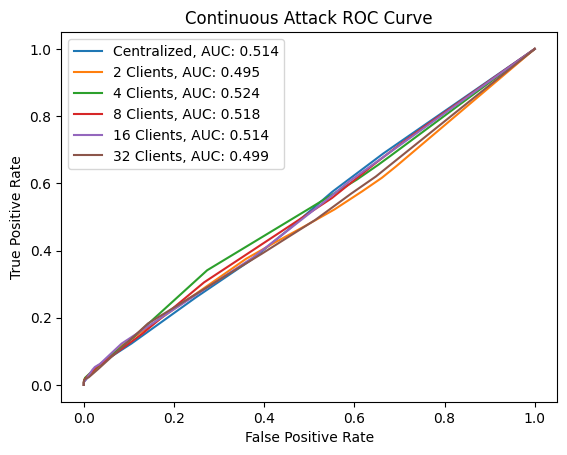

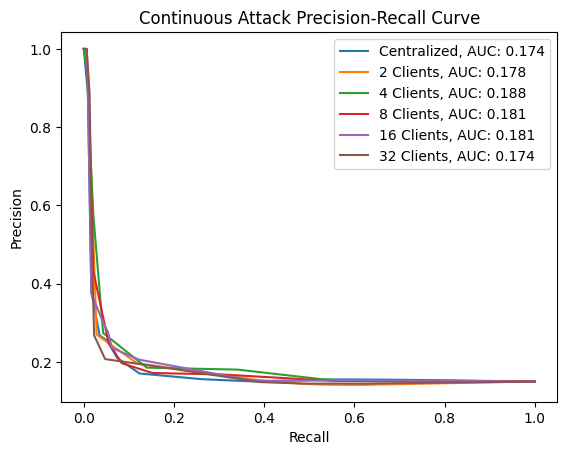


Evaluating flooding attack
Evaluating model "Centralized"
Using threshold 12/12: max
Evaluating model "2 Clients"
Using threshold 12/12: max
Evaluating model "4 Clients"
Using threshold 12/12: max
Evaluating model "8 Clients"
Using threshold 12/12: max
Evaluating model "16 Clients"
Using threshold 12/12: max
Evaluating model "32 Clients"
Using threshold 12/12: max


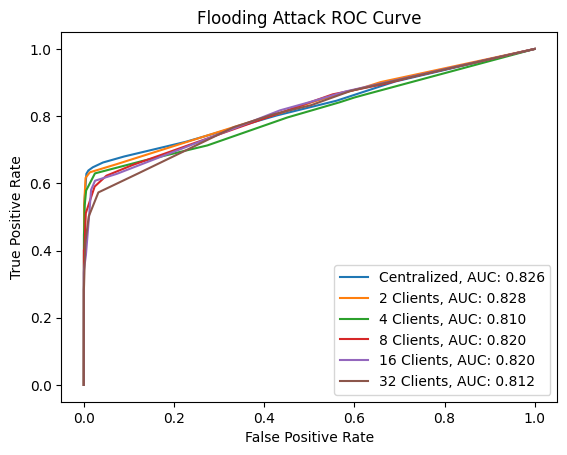

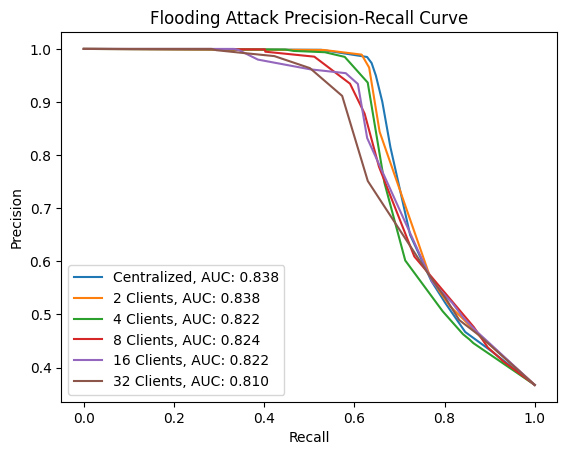


Evaluating plateau attack
Evaluating model "Centralized"
Using threshold 12/12: max
Evaluating model "2 Clients"
Using threshold 12/12: max
Evaluating model "4 Clients"
Using threshold 12/12: max
Evaluating model "8 Clients"
Using threshold 12/12: max
Evaluating model "16 Clients"
Using threshold 12/12: max
Evaluating model "32 Clients"
Using threshold 12/12: max


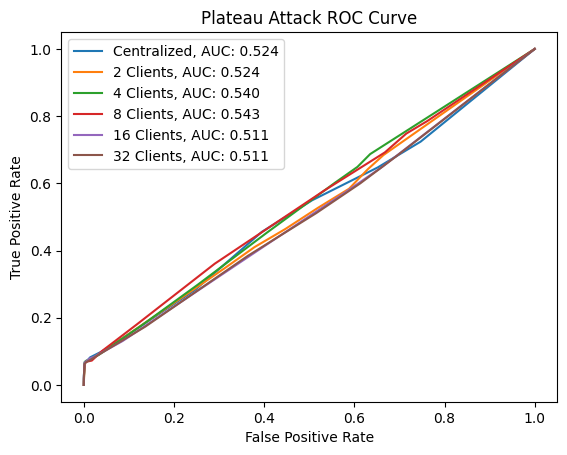

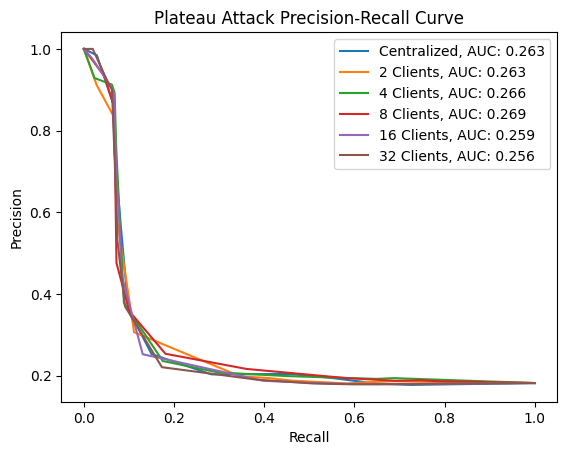

In [ ]:
pr_auc_val_list = []
roc_auc_val_list = []
# model_configs=[(50, 10)]
# for config in model_configs:
config = (50, 10)
print(f'Using model configuration {config}')
params = set_params(id=id, config=config)
models = []
n_client_list = [1, 2, 4, 8, 16, 32]
for num_clients in n_client_list:
    path = params['model_dir']+'FIDSVarClients/id'+str(id)+'/clients'+str(num_clients)+'/global_model_final.h5'
    models.append(tf.keras.models.load_model(path))
evaluator = SynCAN_Evaluator(thresh_df, params, verbose=False)
results = evaluator.batch_evaluate(models, ['Centralized']+[str(n)+' Clients' for n in n_client_list[1:]], eval_dfs, thresh_stds)
print(f'\n')

In [ ]:
results

({'continuous': {'Centralized': 0.5139127417749759,
   '2 Clients': 0.49481771883487463,
   '4 Clients': 0.5235595692413578,
   '8 Clients': 0.5175767921529981,
   '16 Clients': 0.51419778645096,
   '32 Clients': 0.49850234366130675},
  'flooding': {'Centralized': 0.8257724958568093,
   '2 Clients': 0.8281318106748828,
   '4 Clients': 0.8095644463794669,
   '8 Clients': 0.8200314832880774,
   '16 Clients': 0.8195091817960688,
   '32 Clients': 0.8124582913551366},
  'plateau': {'Centralized': 0.5238555320743103,
   '2 Clients': 0.5237403279929064,
   '4 Clients': 0.5399257193963801,
   '8 Clients': 0.5427995885054948,
   '16 Clients': 0.5113692538491935,
   '32 Clients': 0.5108255185981173}},
 {'continuous': {'Centralized': 0.17371414883094052,
   '2 Clients': 0.1776270813928771,
   '4 Clients': 0.1882724967145029,
   '8 Clients': 0.18106305353873495,
   '16 Clients': 0.18134499529341563,
   '32 Clients': 0.17412553014279702},
  'flooding': {'Centralized': 0.8380200269611802,
   '2 Clie

In [ ]:
print('ROC AUC Values')
print(pd.DataFrame(results[0]), f'\n'*2)
print('PR AUC Values')
print(pd.DataFrame(results[1]))

ROC AUC Values
             continuous  flooding   plateau
Centralized    0.513913  0.825772  0.523856
2 Clients      0.494818  0.828132  0.523740
4 Clients      0.523560  0.809564  0.539926
8 Clients      0.517577  0.820031  0.542800
16 Clients     0.514198  0.819509  0.511369
32 Clients     0.498502  0.812458  0.510826 


PR AUC Values
             continuous  flooding   plateau
Centralized    0.173714  0.838020  0.263090
2 Clients      0.177627  0.838090  0.263152
4 Clients      0.188272  0.822431  0.266100
8 Clients      0.181063  0.823526  0.268840
16 Clients     0.181345  0.822310  0.258733
32 Clients     0.174126  0.810464  0.255612


In [ ]:
# cm = sns.light_palette("seagreen", as_cmap=True)
styled_table = pd.DataFrame(results[0]).round(3)
dfi.export(styled_table, 'client_number_roc_auc.png', table_conversion="matplotlib")
styled_table

continuous  flooding  plateau
Centralized       0.514     0.826    0.524
2 Clients         0.495     0.828    0.524
4 Clients         0.524     0.810    0.540
8 Clients         0.518     0.820    0.543
16 Clients        0.514     0.820    0.511
32 Clients        0.499     0.812    0.511

In [ ]:
# cm = sns.light_palette("seagreen", as_cmap=True)
styled_table = pd.DataFrame(results[1]).round(3)
dfi.export(styled_table, 'client_number_pr_auc.png', table_conversion="matplotlib")
styled_table

continuous  flooding  plateau
Centralized       0.174     0.838    0.263
2 Clients         0.178     0.838    0.263
4 Clients         0.188     0.822    0.266
8 Clients         0.181     0.824    0.269
16 Clients        0.181     0.822    0.259
32 Clients        0.174     0.810    0.256

### Data Split Testing

In [ ]:
# model_configs = ((20, 5), (50, 10), (100, 20), (250, 50))
thresh_stds = np.logspace(-2, 4, num=10, base=2)
thresh_stds

array([ 0.25      ,  0.39685026,  0.62996052,  1.        ,  1.58740105,
        2.5198421 ,  4.        ,  6.34960421, 10.0793684 , 16.        ])

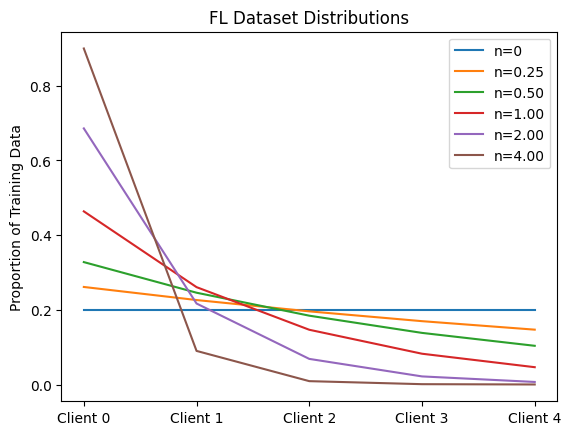

In [ ]:
dists = [np.array(5*[0.2])]
plt.plot(dists[0], label='n=0')
for n in np.logspace(-2, 2, base=2, num=5):
    dist = np.logspace(0, -n, num=5)
    dist = dist/(dist.sum())
    dists.append(dist)
    plt.plot(['Client '+str(i) for i in range(5)], dist, label=f'n={n:.2f}')
plt.title('FL Dataset Distributions')
plt.ylabel('Proportion of Training Data')
plt.legend()
plt.savefig('Distributions.png')
plt.show()

Using model configuration (50, 10)

Evaluating continuous attack
Evaluating model "uniform"
Using threshold 10/11: 16.0000
Evaluating model "n=0.25"
Using threshold 10/11: 16.0000
Evaluating model "n=0.5"
Using threshold 10/11: 16.0000
Evaluating model "n=1"
Using threshold 10/11: 16.0000
Evaluating model "n=2"
Using threshold 10/11: 16.0000
Evaluating model "n=4"
Using threshold 10/11: 16.0000


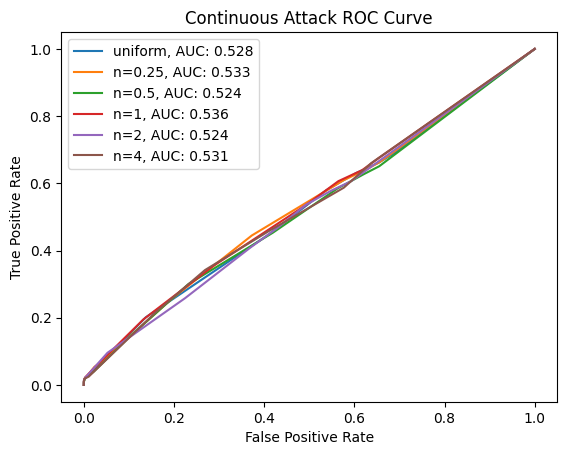

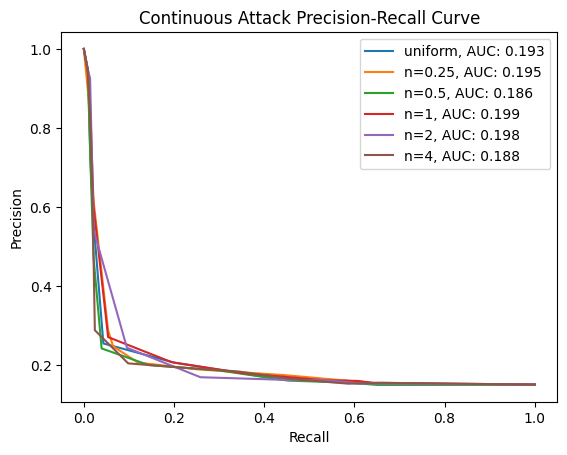


Evaluating flooding attack
Evaluating model "uniform"
Using threshold 10/11: 16.0000
Evaluating model "n=0.25"
Using threshold 10/11: 16.0000
Evaluating model "n=0.5"
Using threshold 10/11: 16.0000
Evaluating model "n=1"
Using threshold 10/11: 16.0000
Evaluating model "n=2"
Using threshold 10/11: 16.0000
Evaluating model "n=4"
Using threshold 10/11: 16.0000


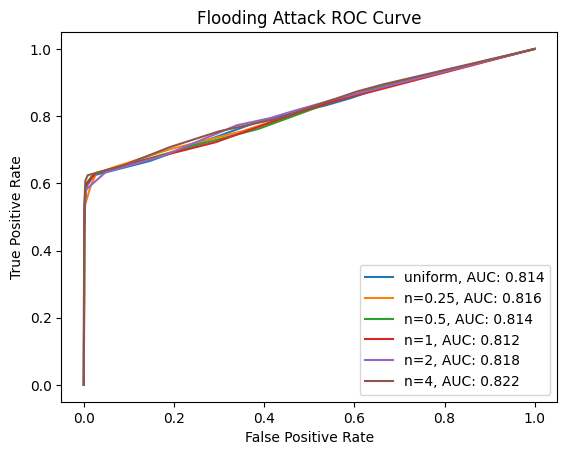

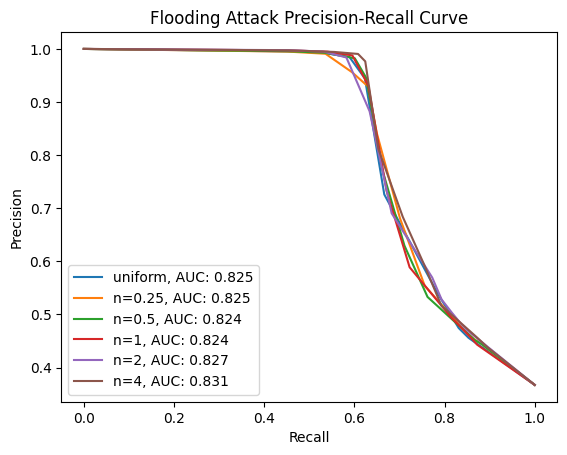


Evaluating plateau attack
Evaluating model "uniform"
Using threshold 10/11: 16.0000
Evaluating model "n=0.25"
Using threshold 10/11: 16.0000
Evaluating model "n=0.5"
Using threshold 10/11: 16.0000
Evaluating model "n=1"
Using threshold 10/11: 16.0000
Evaluating model "n=2"
Using threshold 10/11: 16.0000
Evaluating model "n=4"
Using threshold 10/11: 16.0000


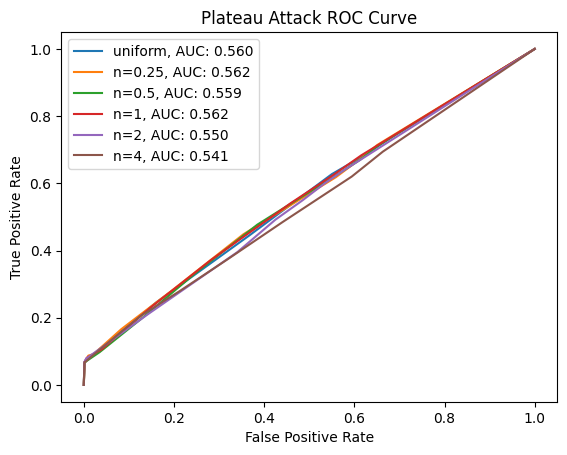

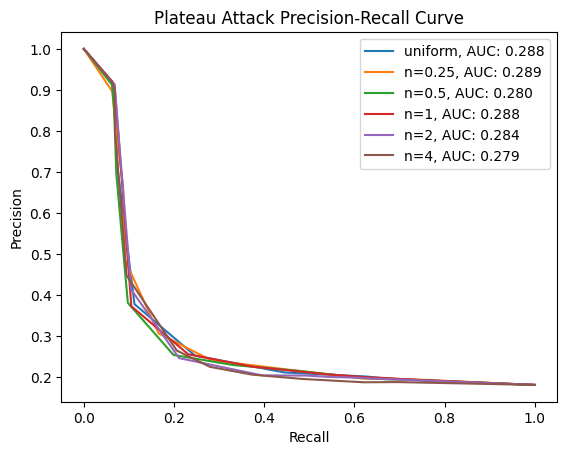

In [ ]:
pr_auc_val_list = []
roc_auc_val_list = []
# model_configs=[(50, 10)]
# for config in model_configs:
config = (50, 10)
print(f'Using model configuration {config}')
params = set_params(id=id, config=config)
models = []
n_list = [0, 0.25, 0.5, 1, 2, 4]
for n in n_list:
    path = params['model_dir']+'FIDSVarDist/id'+str(id)+'/n'+str(n)+'/global_model_final.h5'
    models.append(tf.keras.models.load_model(path))
evaluator = SynCAN_Evaluator(thresh_df, params, verbose=False)
results = evaluator.batch_evaluate(models, ['uniform']+[f'n={n}' for n in n_list[1:]], eval_dfs, thresh_stds)
print(f'\n')

In [ ]:
results

({'continuous': {'uniform': 0.5276663381476816,
   'n=0.25': 0.5333769874985291,
   'n=0.5': 0.5235840405720492,
   'n=1': 0.5359431253573617,
   'n=2': 0.5241269335008211,
   'n=4': 0.5310252326670355},
  'flooding': {'uniform': 0.8144624806929048,
   'n=0.25': 0.8161674675589046,
   'n=0.5': 0.8137591392428284,
   'n=1': 0.8121637341589811,
   'n=2': 0.8176753312108467,
   'n=4': 0.8221309861339692},
  'plateau': {'uniform': 0.5603389021608971,
   'n=0.25': 0.5622543713587572,
   'n=0.5': 0.5593699272853315,
   'n=1': 0.5621469876151993,
   'n=2': 0.5503079298879399,
   'n=4': 0.5405065020389839}},
 {'continuous': {'uniform': 0.19300071381442438,
   'n=0.25': 0.19505106739140013,
   'n=0.5': 0.18645957437795996,
   'n=1': 0.19934615314404142,
   'n=2': 0.19777599407491467,
   'n=4': 0.18813591388793774},
  'flooding': {'uniform': 0.8250594339443282,
   'n=0.25': 0.8254629572959786,
   'n=0.5': 0.8241100450714672,
   'n=1': 0.824191391729143,
   'n=2': 0.8265271328417791,
   'n=4': 0.

In [ ]:
print('ROC AUC Values')
print(pd.DataFrame(results[0]), f'\n'*2)
print('PR AUC Values')
print(pd.DataFrame(results[1]))

ROC AUC Values
         continuous  flooding   plateau
uniform    0.527666  0.814462  0.560339
n=0.25     0.533377  0.816167  0.562254
n=0.5      0.523584  0.813759  0.559370
n=1        0.535943  0.812164  0.562147
n=2        0.524127  0.817675  0.550308
n=4        0.531025  0.822131  0.540507 


PR AUC Values
         continuous  flooding   plateau
uniform    0.193001  0.825059  0.288165
n=0.25     0.195051  0.825463  0.289020
n=0.5      0.186460  0.824110  0.280363
n=1        0.199346  0.824191  0.288321
n=2        0.197776  0.826527  0.284208
n=4        0.188136  0.831444  0.279210


In [ ]:
# cm = sns.light_palette("seagreen", as_cmap=True)
styled_table = pd.DataFrame(results[0]).round(3)
dfi.export(styled_table, 'data_dist_roc_auc.png', table_conversion="matplotlib")
styled_table

continuous  flooding  plateau
uniform       0.528     0.814    0.560
n=0.25        0.533     0.816    0.562
n=0.5         0.524     0.814    0.559
n=1           0.536     0.812    0.562
n=2           0.524     0.818    0.550
n=4           0.531     0.822    0.541

In [ ]:
# cm = sns.light_palette("seagreen", as_cmap=True)
styled_table = pd.DataFrame(results[1]).round(3)
dfi.export(styled_table, 'data_dist_pr_auc.png', table_conversion="matplotlib")
styled_table

continuous  flooding  plateau
uniform       0.193     0.825    0.288
n=0.25        0.195     0.825    0.289
n=0.5         0.186     0.824    0.280
n=1           0.199     0.824    0.288
n=2           0.198     0.827    0.284
n=4           0.188     0.831    0.279

### Visualize Current Reconstruction

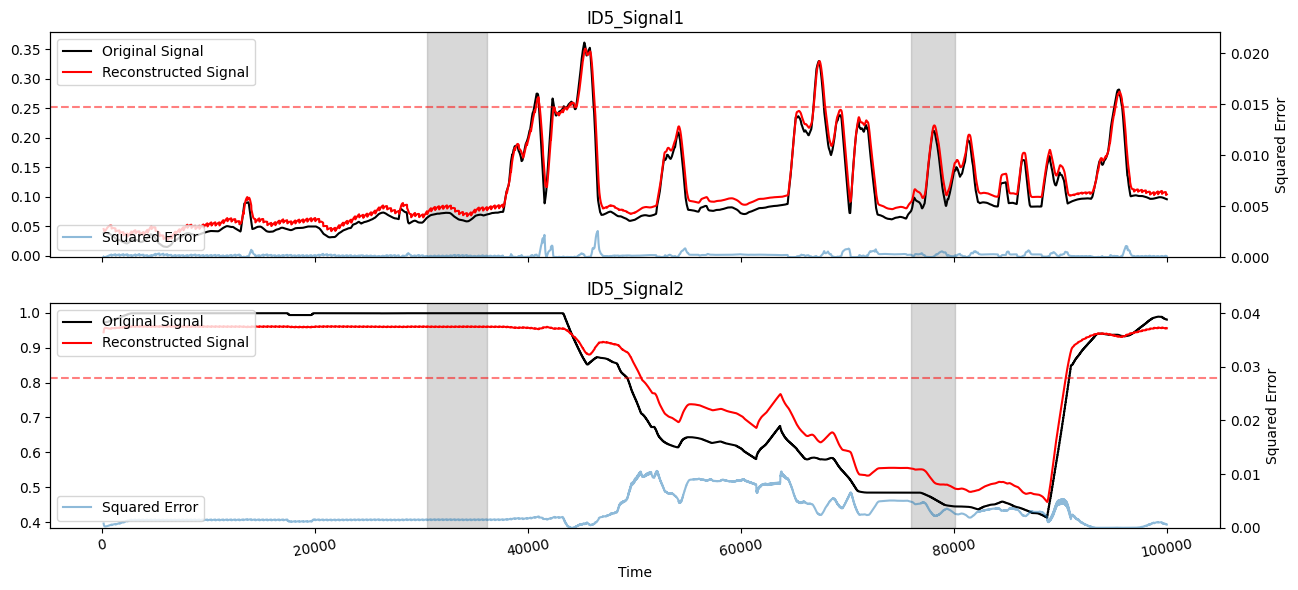

In [ ]:
evaluator.visualize_reconstruction(
    start_time=0,
    end_time=1e5,
    highlight_anomalies=True,
    highlight_predictions=True,
    plot_squared_error=True
)

In [ ]:
evaluator.evaluation_df.index = evaluator.evaluation_df.index

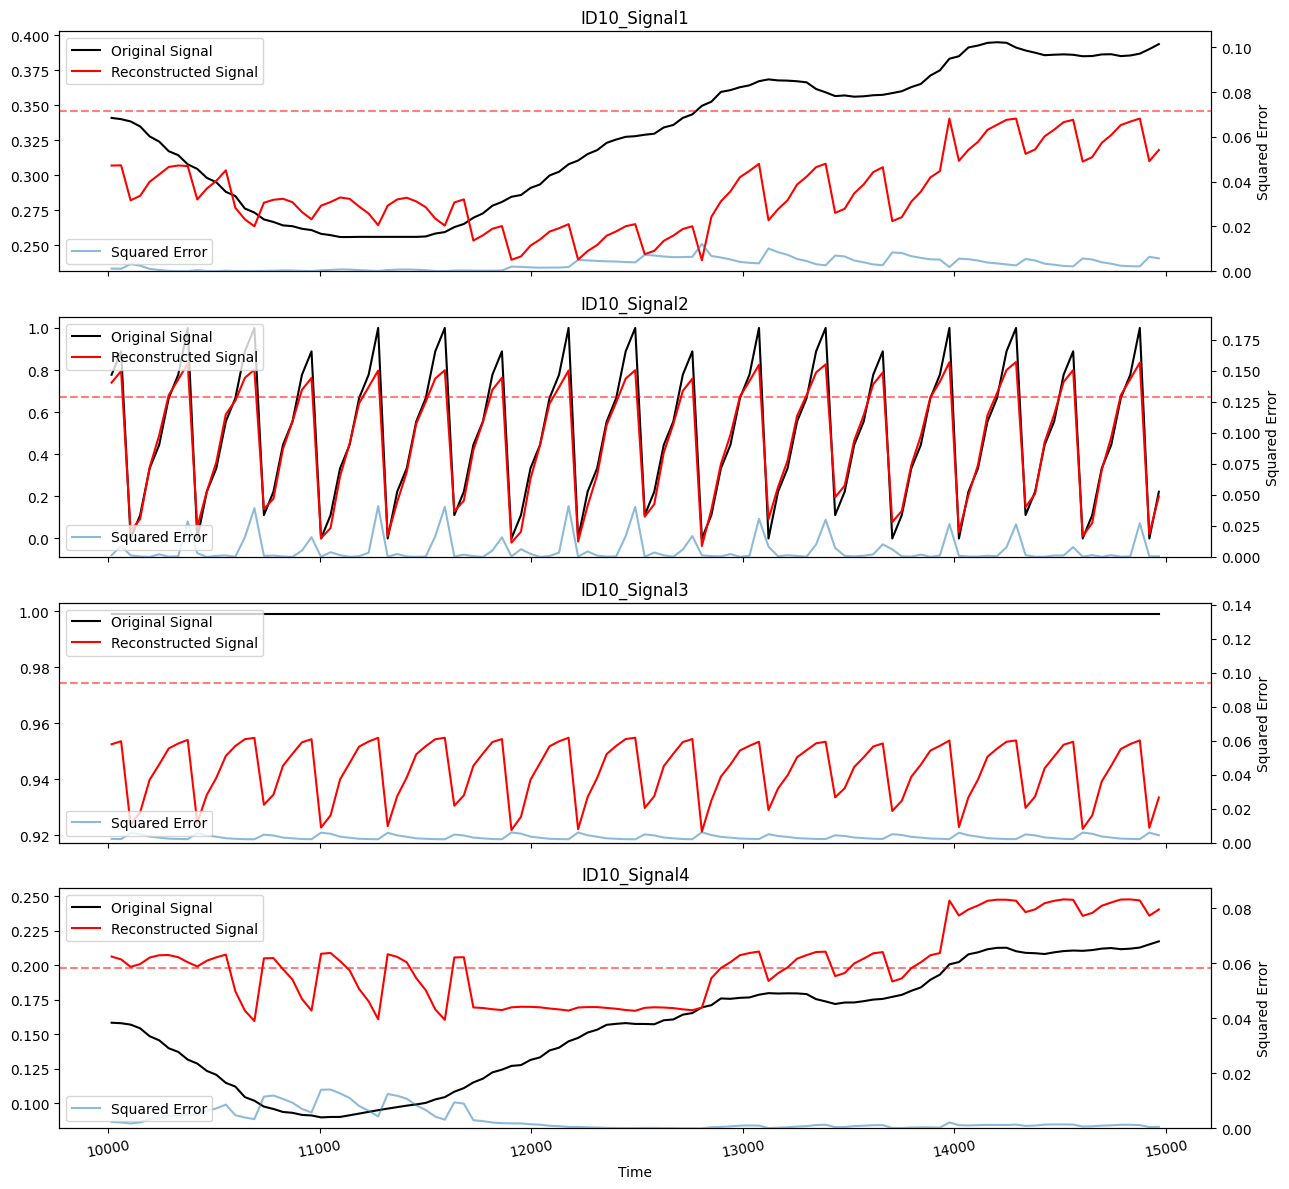

In [ ]:
evaluator.visualize_reconstruction(
    start_time=10e3,
    end_time=15e3,
    highlight_anomalies=True,
    highlight_predictions=True,
    plot_squared_error=True
)